# PostGIS on Python 3 and DBSCAN implementation
In this project, we use the dataset "animale" which contains a trajectory of 1189 points taken from a roe deer. 
The positions are expressed in projected coordinates (EPSG 3857).
We have to implement DBSCAN algorithm in order to find the most densely populated areas from the animal.
The result must be a list of the original points associated to a label. The labels denote the cluster each point belongs to. 
A label equals to 0 denotes a noisepoint.
<br>

Developers: [Luca Arrotta](https://github.com/lucaArrotta), 
[Cheick Tidiane Ba](), 
[Giovanni Laganà](https://bitbucket.org/giolaga/).

***

### PostGIS on Python 3

Create the connection with the database.

In [2]:
import psycopg2
import pandas as pd

def create_connection():
    try:
        return psycopg2.connect("dbname='progetto' user='postgres' host='localhost' password='postgres' port=5433")
    except psycopg2.Error as e:
        print("Unable to connect to the database")
        print(e)

conn = create_connection()

<br>
Test 1: get the name of each db.

In [3]:
cur = conn.cursor()
cur.execute("""
    SELECT datname 
    FROM pg_database""")

rows = cur.fetchall()
print ("Databases:")

for row in rows:
    print("\t", row[0])

Databases:
	 postgres
	 esercitazioni
	 template1
	 template0
	 lab9
	 lab10
	 lab13
	 progetto


<br> 
Test 2: get 10 rows from table Animale(gid, animal, id, time, x, y, geom).

In [4]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM animale 
    LIMIT 10""")
rows = cur.fetchall()

df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom"]
display(df)

,gid,animal,id,time,x,y,geom
0,1,767,1,2005-11-27 16:01:53,1231569.438434269977733,5781498.869216189719737,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...
1,2,767,2,2005-11-28 00:03:00,1231541.552901820046827,5781371.871003749780357,0101000020110F000057F98A8DB5CA32418486BEF7DE0D...
2,3,767,3,2005-11-28 04:01:52,1231879.106993759982288,5781535.539407029747963,0101000020110F00005FF1631B07CC32410BA585E2070E...
3,4,767,4,2005-11-28 08:01:24,1231599.283189750043675,5781672.877671480178833,0101000020110F00009B1F7F48EFCA3241FBC42B382A0E...
4,5,767,5,2005-11-28 12:01:56,1231634.192982059903443,5781679.464961109682918,0101000020110F0000C245673112CB324140ECC1DD2B0E...
5,6,767,6,2005-11-28 16:01:24,1231462.872285729972646,5781463.401208249852061,0101000020110F0000231E4EDF66CA32415B65ADD9F50D...
6,7,767,7,2005-11-28 20:00:53,1231446.107570420019329,5781406.296891699545085,0101000020110F000028BC891B56CA32410E460093E70D...
7,8,767,8,2005-11-29 00:02:20,1231549.456585669890046,5781437.277099739760160,0101000020110F00006DCCE274BDCA32419100BC51EF0D...
8,9,767,9,2005-11-29 12:01:01,1231638.122560089919716,5781744.216195159591734,0101000020110F00001519601F16CB32413E24D60D3C0E...
9,10,767,10,2005-11-29 16:01:47,1231685.010329609969631,5781618.400492999702692,0101000020110F000020F6A40245CB32415FADA1991C0E...


<br>
Test 3: get distances between point with gid=1 and all other points (considering only 10 rows).

In [5]:
cur = conn.cursor()
cur.execute("""
    SELECT a1.gid, a2.gid, ST_distance(a1.geom,a2.geom), a1.geom, a2.geom
    FROM animale a1, animale a2
    WHERE a1.gid = 1 
    LIMIT 10""")

rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["gid_point1", "gid_point2", "distance", "geom1", "geom2"]
display(df)

,gid_point1,gid_point2,distance,geom1,geom2
0,1,1,0.000000,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...
1,1,2,130.023647,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F000057F98A8DB5CA32418486BEF7DE0D...
2,1,3,311.832198,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F00005FF1631B07CC32410BA585E2070E...
3,1,4,176.549290,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F00009B1F7F48EFCA3241FBC42B382A0E...
4,1,5,191.854045,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F0000C245673112CB324140ECC1DD2B0E...
5,1,6,112.313506,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F0000231E4EDF66CA32415B65ADD9F50D...
6,1,7,154.208097,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F000028BC891B56CA32410E460093E70D...
7,1,8,64.752321,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F00006DCCE274BDCA32419100BC51EF0D...
8,1,9,254.779609,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F00001519601F16CB32413E24D60D3C0E...
9,1,10,166.266621,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0101000020110F000020F6A40245CB32415FADA1991C0E...


<br>
Test 4: function which returns the distance matrix between all points.

In [6]:
def get_distance_matrix(conn):
    cur = conn.cursor()
    cur.execute("""
        SELECT a1.gid, a2.gid, ST_distance(a1.geom,a2.geom)
        FROM animale a1, animale a2""")
    rows = cur.fetchall()
    df = pd.DataFrame(rows)
    df.columns = ["gid_point1", "gid_point2", "distance"]
    return df

display(get_distance_matrix(conn).head(10))

,gid_point1,gid_point2,distance
0,1,1,0.000000
1,1,2,130.023647
2,1,3,311.832198
3,1,4,176.549290
4,1,5,191.854045
5,1,6,112.313506
6,1,7,154.208097
7,1,8,64.752321
8,1,9,254.779609
9,1,10,166.266621


<br>
Test 5: create a table.

In [7]:
cur = conn.cursor()
sql = """CREATE TABLE test_table AS (
            SELECT *
            FROM animale
        )"""
cur.execute(sql)
conn.commit() # makes sure the change is shown in the database

<br>
Test 6: add label column to the table.

In [8]:
cur.execute('ALTER TABLE test_table ADD "label" INTEGER')

labels = [0 for i in range(1189)]
for i, el in enumerate(labels):
    q = ''' UPDATE test_table 
            SET label = {} 
            WHERE id = {}
    '''.format(el, i+1)
    cur.execute(q)

conn.commit()

In [9]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM test_table 
    LIMIT 10""")
rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom", "label"]
display(df)

,gid,animal,id,time,x,y,geom,label
0,1,767,1,2005-11-27 16:01:53,1231569.438434269977733,5781498.869216189719737,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,0
1,2,767,2,2005-11-28 00:03:00,1231541.552901820046827,5781371.871003749780357,0101000020110F000057F98A8DB5CA32418486BEF7DE0D...,0
2,3,767,3,2005-11-28 04:01:52,1231879.106993759982288,5781535.539407029747963,0101000020110F00005FF1631B07CC32410BA585E2070E...,0
3,4,767,4,2005-11-28 08:01:24,1231599.283189750043675,5781672.877671480178833,0101000020110F00009B1F7F48EFCA3241FBC42B382A0E...,0
4,5,767,5,2005-11-28 12:01:56,1231634.192982059903443,5781679.464961109682918,0101000020110F0000C245673112CB324140ECC1DD2B0E...,0
5,6,767,6,2005-11-28 16:01:24,1231462.872285729972646,5781463.401208249852061,0101000020110F0000231E4EDF66CA32415B65ADD9F50D...,0
6,7,767,7,2005-11-28 20:00:53,1231446.107570420019329,5781406.296891699545085,0101000020110F000028BC891B56CA32410E460093E70D...,0
7,8,767,8,2005-11-29 00:02:20,1231549.456585669890046,5781437.277099739760160,0101000020110F00006DCCE274BDCA32419100BC51EF0D...,0
8,9,767,9,2005-11-29 12:01:01,1231638.122560089919716,5781744.216195159591734,0101000020110F00001519601F16CB32413E24D60D3C0E...,0
9,10,767,10,2005-11-29 16:01:47,1231685.010329609969631,5781618.400492999702692,0101000020110F000020F6A40245CB32415FADA1991C0E...,0


<br>
Drop the table and close the connection.

In [10]:
cur = conn.cursor()
cur.execute('DROP TABLE test_table')
conn.commit()
conn.close()
cur.close()

***

### DBSCAN Implementation
Supporting functions.

In [11]:
def get_len(conn):
    ''' 
    returns the number of points in the "animale" dataset
    '''
    cur = conn.cursor()
    query = "SELECT count(*) as len\
            FROM animale"
    cur.execute(query)
    length = cur.fetchall()[0][0]
    return length


def get_core_points(eps, minPoints, conn):
    '''
    returns a list with the id of each corepoint found
    '''
    cur = conn.cursor()
    query = "SELECT a1.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom)<={}\
            GROUP BY a1.gid\
            HAVING count(*)>={}+1".format(eps, minPoints)
    cur.execute(query)
    rows = cur.fetchall()
    core_points_list = list()
    for row in rows:
        core_points_list.append(row[0])
    return core_points_list


def get_neighbors(eps, point):
    '''
    returns a list with the neighbours of the input point
    '''
    cur = conn.cursor()
    query = "SELECT a2.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom) <= {} and a1.gid = {}".format(eps, point)
    cur.execute(query)
    rows = cur.fetchall()
    neighbors_list = list()
    for row in rows:
        neighbors_list.append(row[0])
    return neighbors_list
    


def expand_cluster(point, cluster, eps, minPoints, labels):
    '''
    '''
    neighbors_list1 = get_neighbors(eps, point)
    for i, el in enumerate(neighbors_list1):
        if el == 0 or el == -1:  # so the point is "not visited" or "noisepoint"
            labels[i] = cluster
            neighbors_list2 = get_neighbors(eps, el)
            if len(neighbors_list2) >= minPoints:
                neighbors_list1.append(neighbors_list2)
    return

<br>
DBSCAN implementation (without considering time).

In [12]:
def dbscan(eps, minPoints, conn):
    '''
    '''
    len_dataset = get_len(conn)
    labels = [0 for i in range(len_dataset)]  # a list with a 0 for each dataset point
    core_points_list = get_core_points(eps, minPoints, conn)
    
    cluster = 0
    for i, el in enumerate(labels):  # i -> id of each point
        if el == 0:  # so the point is "not visited" 
            if i in core_points_list:  # so the point is a "corepoint"
                cluster += 1
                labels[i] = cluster
                expand_cluster(i, cluster, eps, minPoints, labels)
            else:  # so the point is a "noisepoint" or a "borderpoint"...if it is a "borderpoint" we reach it when we expand one of the clusters
                labels[i] = -1
    return labels
    
    
conn = create_connection()
l = dbscan(300, 200, conn)
print(l)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

<br>
Creation of a table with the result.

In [13]:
cur = conn.cursor()
sql = """CREATE TABLE test_table AS (
            SELECT *
            FROM animale
        )"""
cur.execute(sql)


cur.execute('ALTER TABLE test_table ADD "label" INTEGER')
for i, el in enumerate(l):
    q = ''' UPDATE test_table 
            SET label = {} 
            WHERE id = {}
    '''.format(el, i+1)
    cur.execute(q)

conn.commit()

In [14]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM test_table 
    LIMIT 10""")
rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom", "label"]
display(df)

conn.close()
cur.close()

,gid,animal,id,time,x,y,geom,label
0,1,767,1,2005-11-27 16:01:53,1231569.438434269977733,5781498.869216189719737,0101000020110F0000713A3D70D1CA3241F43CA1B7FE0D...,-1
1,2,767,2,2005-11-28 00:03:00,1231541.552901820046827,5781371.871003749780357,0101000020110F000057F98A8DB5CA32418486BEF7DE0D...,-1
2,3,767,3,2005-11-28 04:01:52,1231879.106993759982288,5781535.539407029747963,0101000020110F00005FF1631B07CC32410BA585E2070E...,-1
3,4,767,4,2005-11-28 08:01:24,1231599.283189750043675,5781672.877671480178833,0101000020110F00009B1F7F48EFCA3241FBC42B382A0E...,-1
4,5,767,5,2005-11-28 12:01:56,1231634.192982059903443,5781679.464961109682918,0101000020110F0000C245673112CB324140ECC1DD2B0E...,-1
5,6,767,6,2005-11-28 16:01:24,1231462.872285729972646,5781463.401208249852061,0101000020110F0000231E4EDF66CA32415B65ADD9F50D...,-1
6,7,767,7,2005-11-28 20:00:53,1231446.107570420019329,5781406.296891699545085,0101000020110F000028BC891B56CA32410E460093E70D...,-1
7,8,767,8,2005-11-29 00:02:20,1231549.456585669890046,5781437.277099739760160,0101000020110F00006DCCE274BDCA32419100BC51EF0D...,-1
8,9,767,9,2005-11-29 12:01:01,1231638.122560089919716,5781744.216195159591734,0101000020110F00001519601F16CB32413E24D60D3C0E...,-1
9,10,767,10,2005-11-29 16:01:47,1231685.010329609969631,5781618.400492999702692,0101000020110F000020F6A40245CB32415FADA1991C0E...,-1


<br>
Plot the result with matplotlib.

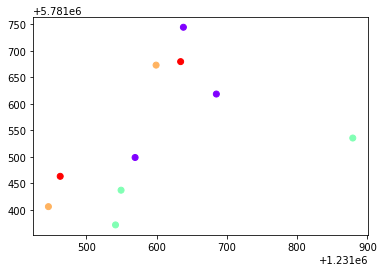

In [41]:
import matplotlib.pyplot as plt
import matplotlib

xs = [tup[4] for tup in rows]
ys = [tup[5] for tup in rows]
ls = [tup[7] for tup in rows]
ls = [-1, 1, 1, 2, 3, 3, 2, 1, -1, -1]  # istruzione da cancellare

plt.scatter(xs, ys, c=ls, cmap="rainbow")
plt.show()

<br>
Result from QGIS.

![test](img/screen1.PNG)